In [1]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchmetrics

import pandas as pd
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import gensim.downloader
from sklearn.linear_model import LinearRegression
import swifter

device = 'cpu'

In [2]:
df = pd.read_json('gutenberg-dataset-v2.json')
# df = pd.read_json('dataset.json')
embedding_vectors = gensim.downloader.load('glove-twitter-25')

embedding_dim = len(embedding_vectors['test'])


In [2]:
chunk_size = 2000
input_size = 25 * chunk_size

In [3]:
df = df.sample(frac=0.3)

In [4]:
df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('weights', axis=1).drop('text_len_characters', axis=1))


In [5]:
tqdm.pandas()

def embed_texts(text):
    words = text.split()
    if len(words) != chunk_size:
        print("error wrong word count")
    embeddings = []

    for word in words: 
        if word not in embedding_vectors:
            embeddings.append(np.zeros(embedding_dim))
        else:
            e = embedding_vectors[word]
            assert(len(e) == embedding_dim)
            embeddings.append(embedding_vectors[word])

    return np.concatenate(embeddings)

        

df['text'] = df['text'].progress_apply(embed_texts)
# df['text_embed'] = df['text'].progress_apply(lambda text: np.array([embedding_vectors[word] if word in embedding_vectors else embedding_vectors['none'] for word in text.split() if word in embedding_vectors]).flatten())


  0%|          | 0/36049 [00:00<?, ?it/s]

In [6]:
X_all = np.concatenate(df['text'].values).reshape((len(df), 25*2000))


In [7]:
df['date'] = (df['date']-df['date'].min())/(df['date'].max()-df['date'].min())

df
y_all = df['date'].values

In [17]:
np.save('X_all', X_all)
np.save('y_all', y_all)

In [3]:
X_all = np.load('X_all.npy')
y_all = np.load('y_all.npy')

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=True)

In [9]:
#train_dataloader = DataLoader((torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=16)
#test_dataloader = DataLoader((torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=16)

In [4]:
# Define the linear regression model



class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 10000)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(10000, 10000)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(10000, 1000)
        self.activation3 = nn.ReLU()
        self.linear4 = nn.Linear(1000, 100)
        self.activation4 = nn.ReLU()
        self.linear5 = nn.Linear(100, 1)
        self.activation5 = nn.Sigmoid()
        

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        x = self.linear5(x)
        x = self.activation5(x)

        return x

In [11]:
df.isnull().values.any()


False

In [5]:
# Initialize the model, loss function, and optimizer

num_epochs = 2
loading_steps = 10
loading_count = 0

learning_rate = 0.001

input_size = X_train.shape[1]

model = LinearRegressionModel(input_size)
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=len(X_train_tensor) // 1, shuffle=True)

losses = []


model.train()

for epoch in tqdm(range(num_epochs)):

    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    if epoch % (num_epochs / loading_steps) == 0:
        print(f'{loading_count}0% done')
        print(f'Loss: {loss}')
        loading_count = loading_count + 1

print('finished')


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

00% done
Loss: 0.6910541653633118


  0%|          | 0/1 [00:00<?, ?it/s]

finished


In [7]:
model.train()
for epoch in tqdm(range(5)):

    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    
    print(f'{loading_count}0% done')
    print(f'Loss: {loss}')
    loading_count = loading_count + 1

print('finished')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10% done
Loss: 43.18246078491211


  0%|          | 0/1 [00:00<?, ?it/s]

20% done
Loss: 43.18246078491211


  0%|          | 0/1 [00:00<?, ?it/s]

30% done
Loss: 43.18246078491211


  0%|          | 0/1 [00:00<?, ?it/s]

40% done
Loss: 43.18246078491211


  0%|          | 0/1 [00:00<?, ?it/s]

50% done
Loss: 43.18246078491211
finished


Mean Squared Error: 0.20559744602154661


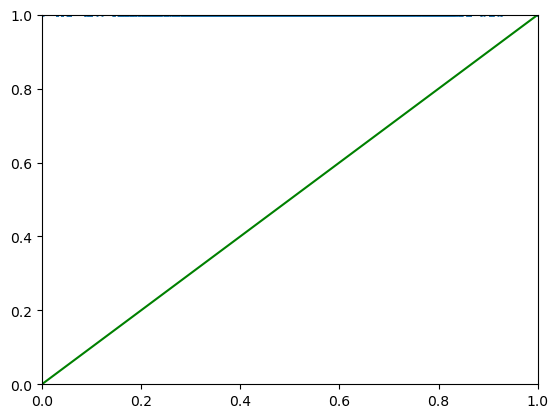

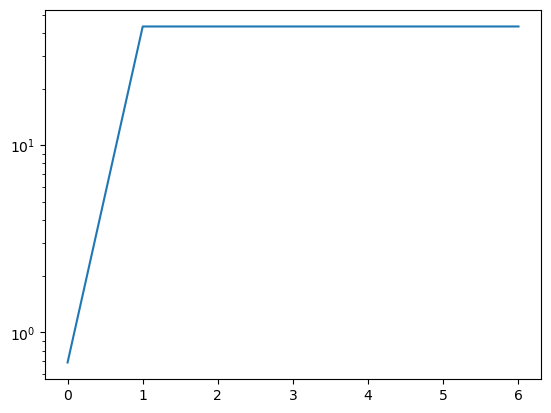

In [8]:
model.eval()


with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_pred = model(X_test_tensor).detach().numpy()

    # Calculate the mean squared error to evaluate the model
    mse = ((y_test - y_pred) ** 2).mean()
    print(f"Mean Squared Error: {mse}")

    # plt.hist(y_pred, bins=100)
    # plt.show()

    # plt.hist(y_test, bins=100)
    # plt.show()


    plt.scatter(y_test, y_pred, s=1)

    plt.axline([0, 0], [1, 1], color='green')

    m, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, m * y_test + b, color='red')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

    plt.plot(losses)
    plt.yscale('log')
    #plt.ylim(0, 0.01)
    plt.show()





# coeff_list = []
# name_list = []
# # View the coefficients
# with torch.no_grad():
#     coefficients = model.linear.weight.view(-1).numpy()

#     for i, coef in enumerate(coefficients):
#         coeff_list.append(coef)
#         name_list.append(X.columns[i])

# coef_df = pd.DataFrame(data={'names': name_list, 'coefficients': coeff_list}).sort_values('coefficients', ascending=False)

# coef_df